从下面的BertModel跳转访问源码，可以发现BertModel主要分为三个部分：embedding、encoder、poller
当前主要关注embedding 部分
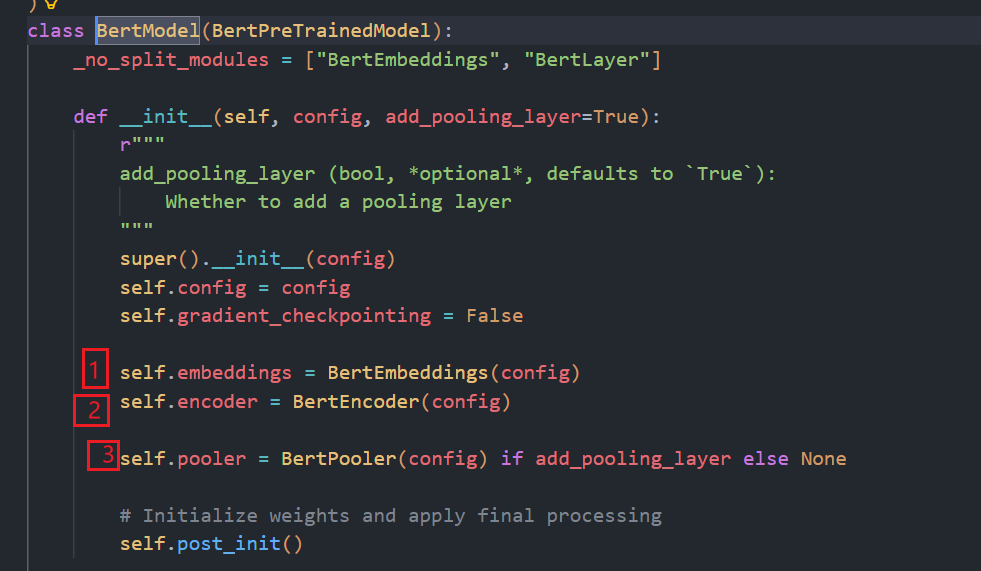

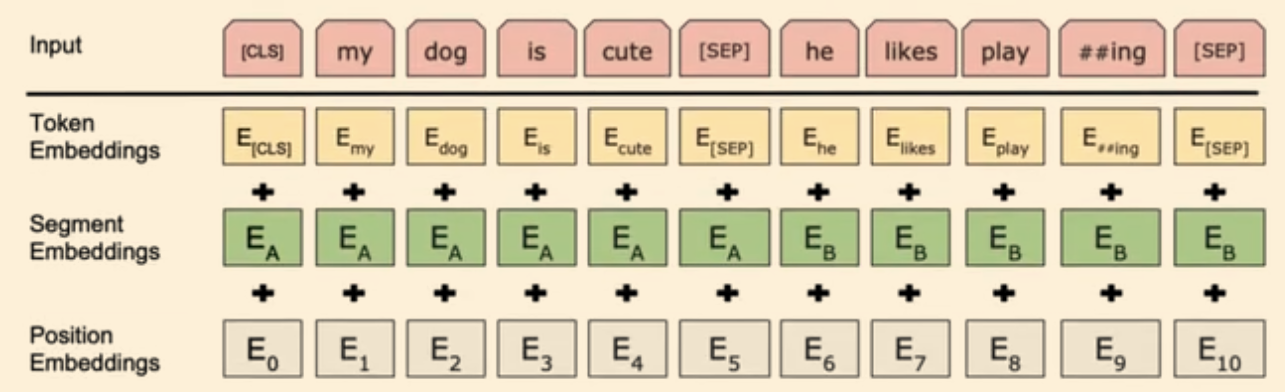

## summary
- bert input embedding: 一种查表操作（lookup table）（三种embedding都是查表）
    - 查表
        - token embeddings: 305522*768（hideen space 隐藏层的维度都是768 ）
        - segment embeddings: 0/1 *8 = 768 #用来区分第一句还是第二句
        - position embeddings: 512*768 #句子默认最大长度为512tokens，768维的
    - 后处理
        - layer norm
        - dropout


In [1]:
from transformers.models.bert import BertModel

In [2]:
from transformers import BertTokenizer,BertModel
import torch
from torch import  nn

In [3]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\ex.qianwei.sun\AppData\Local\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ex.qianwei.sun\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
test_sent = 'this is a test sentence'

In [5]:
input = tokenizer(test_sent, return_tensors='pt')


In [6]:
input
# token_type_ids 输入的是第一句：0；还是第二句：1；
# attention_mask 用来区分padding的位置，因为一般要把数据预处理成定长的


{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231, 6251,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [7]:
input_ids = input['input_ids']
token_type_ids = input['token_type_ids']

In [8]:
pos_ids = torch.arange(input_ids.shape[1])

In [10]:
pos_ids.shape

torch.Size([7])

In [9]:
pos_ids

tensor([0, 1, 2, 3, 4, 5, 6])

## 1.token embedding

In [11]:
token_embeddings = model.embeddings.word_embeddings(input_ids)

In [19]:
token_embeddings.shape

torch.Size([1, 7, 768])

## 2.segment embedding

In [13]:
seg_embed = model.embeddings.token_type_embeddings(token_type_ids)


In [17]:
seg_embed.shape

torch.Size([1, 7, 768])

## 3.position embedding

In [14]:
pos_embed = model.embeddings.position_embeddings(pos_ids)


In [15]:
pos_embed

tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [-5.6087e-03, -1.0445e-02, -7.2288e-03,  ...,  2.0837e-02,
          3.5402e-03,  4.7708e-03],
        [-3.0871e-03, -1.8956e-02, -1.8930e-02,  ...,  7.4045e-03,
          2.0183e-02,  3.4077e-03],
        [ 6.4257e-03, -1.7664e-02, -2.2067e-02,  ...,  6.7531e-04,
          1.1108e-02,  3.7521e-03]], grad_fn=<EmbeddingBackward0>)

In [18]:
pos_embed.shape

torch.Size([7, 768])

## 4. input embedding

In [21]:
input_embed = token_embeddings + seg_embed + pos_embed.unsqueeze(0)


In [22]:
input_embed

tensor([[[ 0.0316, -0.0411, -0.0564,  ...,  0.0021,  0.0044,  0.0219],
         [-0.0489,  0.0285, -0.0204,  ...,  0.0190,  0.0265, -0.0045],
         [-0.0469, -0.0156, -0.0336,  ...,  0.0117,  0.0135,  0.0109],
         ...,
         [ 0.0185, -0.0608, -0.0331,  ...,  0.0040, -0.0071, -0.1213],
         [ 0.0294, -0.0017, -0.0217,  ..., -0.0004, -0.0913, -0.0948],
         [-0.0077, -0.0166, -0.0123,  ..., -0.0310,  0.0124, -0.0064]]],
       grad_fn=<AddBackward0>)

In [7]:
model.embeddings(input_ids, token_type_ids)

tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [-0.6485,  0.6739, -0.0932,  ...,  0.4475,  0.6696,  0.1820],
         [-0.6270, -0.0633, -0.3143,  ...,  0.3427,  0.4636,  0.4594],
         ...,
         [ 0.6010, -0.6970, -0.2001,  ...,  0.2960,  0.2060, -1.7181],
         [ 0.8323,  0.2878,  0.0021,  ...,  0.2628, -1.1310, -1.2708],
         [-0.1481, -0.2948, -0.1690,  ..., -0.5009,  0.2544, -0.0700]]],
       grad_fn=<NativeLayerNormBackward0>)